In [ ]:
import pulp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.spatial import distance_matrix

# === Problem Setup ===

#
# drone_starts = {
#     'd0': (0, 0),
#     'd1': (10, 0),
#     'd2': (5, 5)
# }

# task_locations = {
#     't0': (2, 8),
#     't1': (7, 4),
#     't2': (10, 10)
# }
#
# num_drones = len(drone_starts)
# num_tasks = len(task_locations) 

load_drones = False     # Load saved drone starts from a JSON file
save_drones = True      # Save generated drone starts to a JSON file

load_tasks = load_drones
save_tasks = save_drones

size = 5              # Number of drones and tasks to create if not loading
max_bound = 15        # Grid size for random generation

if load_drones:
    # Load drone starts from a JSON file
    with open("./drone_starts.json", "r") as f:
        drone_starts = json.load(f)

    # Convert string keys to tuples if needed
    drone_starts = {k: tuple(v) for k, v in drone_starts.items()}

else:
    # creating random drone starting locations
    num_drones = size
    drone_starts = {
        f'd{i}': (np.random.uniform(0, max_bound), np.random.uniform(0, max_bound)) for i in range(num_drones)
    }


if load_tasks:
    # Load task locations from a JSON file
    with open("./task_locations.json", "r") as f:
        task_locations = json.load(f)

    # Convert string keys to tuples if needed
    task_locations = {k: tuple(v) for k, v in task_locations.items()}

else:
    # creating random task locations
    num_tasks = num_drones
    task_locations = {
        f't{i}': (np.random.uniform(0, max_bound), np.random.uniform(0, max_bound)) for i in range(num_tasks)
    }

# Combine all nodes
all_nodes = list(drone_starts.keys()) + list(task_locations.keys())
locations = {**drone_starts, **task_locations}

print("All Nodes and Locations:")
for node, loc in locations.items():
    print(f"{node}: ({loc[0]:.2f}, {loc[1]:.2f})")

# Create index mapping for distance matrix
node_indices = {node: i for i, node in enumerate(all_nodes)}
coords = [locations[node] for node in all_nodes]

# Distance matrix
dist_matrix = distance_matrix(coords, coords)

# Create a DataFrame for the distance matrix
distance_df = pd.DataFrame(dist_matrix, index=all_nodes, columns=all_nodes)
print("\n=== Distance Matrix (Euclidean distances) ===")
print(distance_df.round(2))  # Rounded to 2 decimal places


All Nodes and Locations:
d0: (0.32, 14.67)
d1: (10.85, 11.67)
d2: (13.26, 13.19)
d3: (1.33, 14.54)
d4: (7.15, 10.36)
t0: (14.51, 0.60)
t1: (9.79, 2.10)
t2: (3.74, 13.41)
t3: (11.34, 14.92)
t4: (1.97, 4.32)

=== Distance Matrix (Euclidean distances) ===
       d0     d1     d2     d3     d4     t0     t1     t2     t3     t4
d0   0.00  10.95  13.02   1.02   8.08  19.99  15.74   3.65  11.02  10.48
d1  10.95   0.00   2.85   9.94   3.92  11.66   9.63   7.32   3.28  11.52
d2  13.02   2.85   0.00  12.00   6.73  12.65  11.62   9.52   2.58  14.35
d3   1.02   9.94  12.00   0.00   7.16  19.18  15.04   2.66  10.01  10.24
d4   8.08   3.92   6.73   7.16   0.00  12.23   8.67   4.58   6.19   7.95
t0  19.99  11.66  12.65  19.18  12.23   0.00   4.96  16.74  14.67  13.08
t1  15.74   9.63  11.62  15.04   8.67   4.96   0.00  12.83  12.91   8.13
t2   3.65   7.32   9.52   2.66   4.58  16.74  12.83   0.00   7.75   9.26
t3  11.02   3.28   2.58  10.01   6.19  14.67  12.91   7.75   0.00  14.14
t4  10.48  11.52 

In [2]:

# === Mixed-Integer Linear Programming Formulation ===
n_nodes = len(all_nodes)
n_tasks = len(task_locations)
n_drones = len(drone_starts)
tasks = list(task_locations.keys())
drones = list(drone_starts.keys())

# Decision variables: x[i][j] = 1 if path from node i to node j is used
prob = pulp.LpProblem("Drone_Task_Allocation", pulp.LpMinimize)
x = pulp.LpVariable.dicts("x", ((i, j) for i in range(n_nodes) for j in range(n_nodes) if i != j), cat="Binary")

# Subtour elimination variable (MTZ)
u = pulp.LpVariable.dicts("u", range(n_nodes), lowBound=0, upBound=n_tasks, cat="Continuous")

# Objective: Minimize total distance
prob += pulp.lpSum(dist_matrix[i][j] * x[(i, j)] for i in range(n_nodes) for j in range(n_nodes) if i != j)

# === Constraints ===

# 1. Each task has exactly one incoming and possibly one outgoing connection
task_idxs = [node_indices[t] for t in tasks]
for k in task_idxs:
    prob += pulp.lpSum(x[(i, k)] for i in range(n_nodes) if i != k) == 1
    prob += pulp.lpSum(x[(k, j)] for j in range(n_nodes) if j != k) <= 1

# 2. Drones can only depart once from their start
drone_idxs = [node_indices[d] for d in drones]
for d in drone_idxs:
    prob += pulp.lpSum(x[(d, j)] for j in range(n_nodes) if j != d) == 1
    # (== 1) means each drone needs to have at least 1 task
    # (<= 1) means it is possible for drones to have 0 tasks if optimal

# 3. No incoming edges to drone starts
for d in drone_idxs:
    prob += pulp.lpSum(x[(i, d)] for i in range(n_nodes) if i != d) == 0

# 4. MTZ constraints (to eliminate subtours)
for i in task_idxs:
    for j in task_idxs:
        if i != j:
            prob += u[i] - u[j] + (n_tasks) * x[(i, j)] <= n_tasks - 1

# === Solve ===
prob.solve()
print("Status:", pulp.LpStatus[prob.status])
print("Total Distance:", pulp.value(prob.objective))

# === Extract and Print Routes ===
routes = {d: [] for d in drones}
edges = {(i, j): pulp.value(x[(i, j)]) for (i, j) in x if pulp.value(x[(i, j)]) == 1}

# Initialize an empty DataFrame for x[i][j]
x_matrix = pd.DataFrame(0, index=all_nodes, columns=all_nodes)

# Fill the matrix with solver values (1 if edge is used)
for (i, j), val in x.items():
    if pulp.value(val) > 0.5:  # Binary variable, check if it's 1
        x_matrix.iloc[i, j] = 1

print("\n=== x[i][j] Solution Matrix (1 = path used) ===")
print(x_matrix)


# Build routes starting from each drone
for d in drones:
    path = [d]
    current = node_indices[d]
    visited = set()
    while True:
        next_node = None
        for j in range(n_nodes):
            if current != j and (current, j) in edges:
                next_node = j
                break
        if next_node is None:
            break
        visited.add(current)
        current = next_node
        path.append(all_nodes[current])
    print(f"Drone Route: {' -> '.join(path)}")


Status: Optimal
Total Distance: 36.05553317497034

=== x[i][j] Solution Matrix (1 = path used) ===
    d0  d1  d2  d3  d4  t0  t1  t2  t3  t4
d0   0   0   0   0   0   0   0   0   0   1
d1   0   0   0   0   0   1   0   0   0   0
d2   0   0   0   0   0   0   0   0   1   0
d3   0   0   0   0   0   0   0   1   0   0
d4   0   0   0   0   0   0   1   0   0   0
t0   0   0   0   0   0   0   0   0   0   0
t1   0   0   0   0   0   0   0   0   0   0
t2   0   0   0   0   0   0   0   0   0   0
t3   0   0   0   0   0   0   0   0   0   0
t4   0   0   0   0   0   0   0   0   0   0
Drone Route: d0 -> t4
Drone Route: d1 -> t0
Drone Route: d2 -> t3
Drone Route: d3 -> t2
Drone Route: d4 -> t1


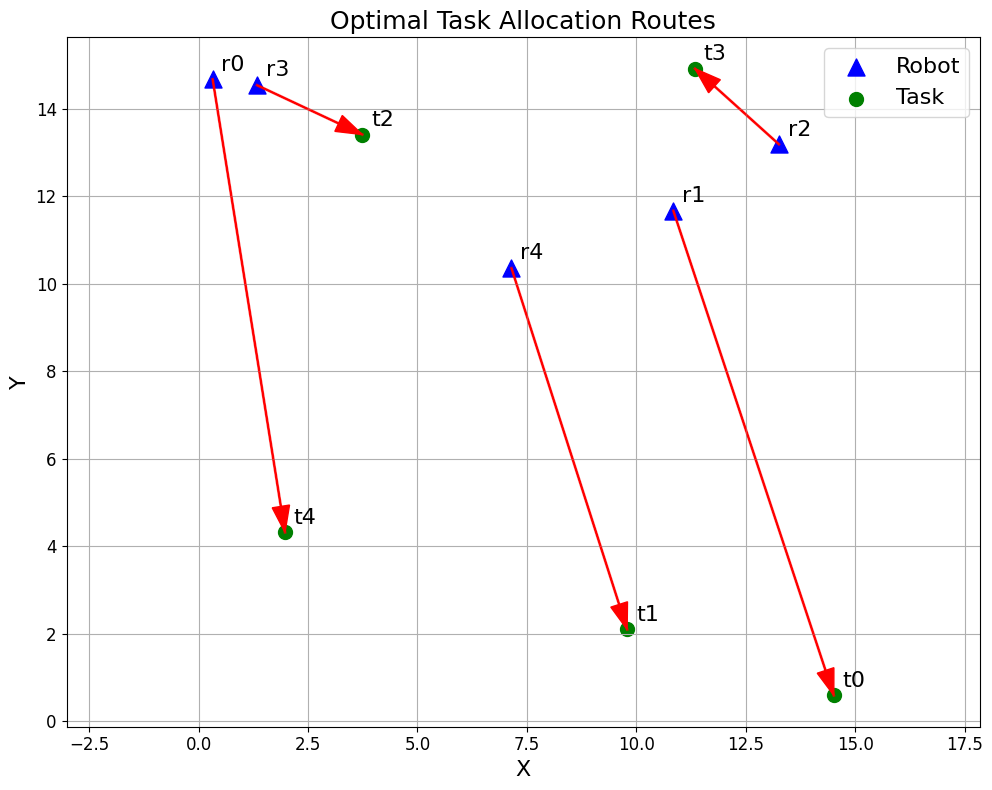

Status: Optimal
Total Distance: 36.05553317497034


In [5]:


# === Extract positions ===
drone_positions = [locations[d] for d in drones]
task_positions = [locations[t] for t in tasks]

# === Plot setup ===
plt.figure(figsize=(10, 8))
plt.title("Optimal Task Allocation Routes", fontsize=18)
plt.xlabel("X", fontsize=16)
plt.ylabel("Y",fontsize=16)

# Plot drones
for i, d in enumerate(drones):
    x_pos, y_pos = locations[d]
    plt.scatter(x_pos, y_pos, c='blue', marker='^', s=150, label="Robot" if i == 0 else "")
    plt.text(x_pos + 0.2, y_pos + 0.2, "r"+str(i), fontsize=16)

# Plot tasks
for i, t in enumerate(tasks):
    x_pos, y_pos = locations[t]
    plt.scatter(x_pos, y_pos, c='green', marker='o', s=100, label="Task" if i == 0 else "")
    plt.text(x_pos + 0.2, y_pos + 0.2, t, fontsize=16)

# === Plot paths from x[i][j] ===
for (i, j), val in x.items():
    if pulp.value(val) > 0.5:
        start = all_nodes[i]
        end = all_nodes[j]
        x_coords = [locations[start][0], locations[end][0]]
        y_coords = [locations[start][1], locations[end][1]]
        plt.plot(x_coords, y_coords, 'r-', linewidth=2, alpha=0.7)
        plt.arrow(
            x_coords[0], y_coords[0],
            x_coords[1] - x_coords[0],
            y_coords[1] - y_coords[0],
            head_width=0.4, head_length=0.6, fc='red', ec='red', length_includes_head=True
        )

# === Finalize plot ===
plt.legend(loc='best', fontsize=16)
plt.grid(True)
plt.axis('equal')
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

print("Status:", pulp.LpStatus[prob.status])
print("Total Distance:", pulp.value(prob.objective))

In [4]:
if save_tasks:
    # Save task locations to a JSON file
    with open("./task_locations.json", "w") as f:
        json.dump(task_locations, f)

if save_drones:
    # Save task locations to a JSON file
    with open("./drone_starts.json", "w") as f:
        json.dump(drone_starts, f)
